## End-to-End Machine Learning Pipeline Using Logistic Regression with Data Analysis
Summary:

	•	Pipeline Setup: We defined a pipeline for data preprocessing, feature engineering, and model training.
	•	Multiple Models: Logistic Regression, Random Forest, and SVM models were tested.
	•	Hyperparameter Tuning: GridSearchCV was used to find the best model and hyperparameters.
	•	Model Evaluation: The best model was evaluated on the test set, and its performance was analyzed.
	•	Inference Pipeline: The best model was saved and loaded into an inference pipeline, which can be deployed via an API for real-time predictions.

### 1. Installing the Libraries

(If you’ve already installed these libraries, you can skip this step.)

In [ ]:
# !pip install pandas numpy scikit-learn joblib flask matplotlib seaborn

### 2. Importing the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump


### 3. Data Collection

In [ ]:
def get_data():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer(as_frame=True)
    df = pd.concat([data['data'], data['target']], axis=1)
    return df

# Load the Breast Cancer Wisconsin dataset
data = get_data()

# Display the first few rows
data.head()

### 4. Exploratory Data Analysis (EDA)

Let’s perform some data analysis to understand the distribution of the features and their relationships with the target variable.

In [ ]:
data.columns

In [ ]:
# Summary statistics
print(data.describe())


### 

In [ ]:
# Checking for missing values
print(data.isnull().sum())

In [ ]:
# Distribution of the target variable
sns.countplot(x=data['target'])
plt.title('Distribution of Target Variable (Malignant vs Benign)')
plt.show()


#### Mutual information and feature importance:
- mutual_info_classif: This function calculates the mutual information between each feature and the target, which helps in identifying how much information each feature contributes to predicting the target.
- Visualization: The code creates a bar plot to visualize the importance of each feature based on mutual information scores.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Split the data into features and target
X = data.drop("target", axis=1)
y = data["target"]

def Show_Feature_Score(X,y):
    # Compute the mutual information scores
    mi_scores = mutual_info_classif(X, y, random_state=42)

    # Create a DataFrame to display the scores
    mi_scores_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual Information': mi_scores
    })

    # Sort the DataFrame by mutual information scores
    mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

    # Visualize the mutual information scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette="viridis")
    plt.title('Mutual Information Scores for Each Feature')
    plt.show()

Show_Feature_Score(X,y)

In [ ]:
def add_combined_feature(X):
    X = X.copy()  # Ensure we're modifying a copy of the DataFrame
    
    # Example feature: combining two features
    X['Combined_radius_texture'] = X['mean radius'] * X['mean texture']
    
    return X

# Apply feature engineering
X = data.drop(columns=['target'])
y = data['target']
X = add_combined_feature(X)
X.columns

In [ ]:
Show_Feature_Score(X,y)

In [4]:
from sklearn.preprocessing import FunctionTransformer

# Define the feature engineering and preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_combined_feature)),
    ('scaler', StandardScaler())
])

# Define the models and their hyperparameters for GridSearchCV
models = [
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1.0, 10]
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
]

# Updated pipeline with additional feature engineering and data transformation steps
training_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', LogisticRegression()) # Placeholder, will be replaced by GridSearchCV
])

# Split the data into training and testing sets
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Hyperparameter Tuning and Model Selection

In [5]:
# Use GridSearchCV to find the best model and hyperparameters
grid_search = GridSearchCV(training_pipeline, models, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

# Best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best parameters found: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 1.0}
Best cross-validation score: 0.97


### Evaluate the Best Model

Test Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



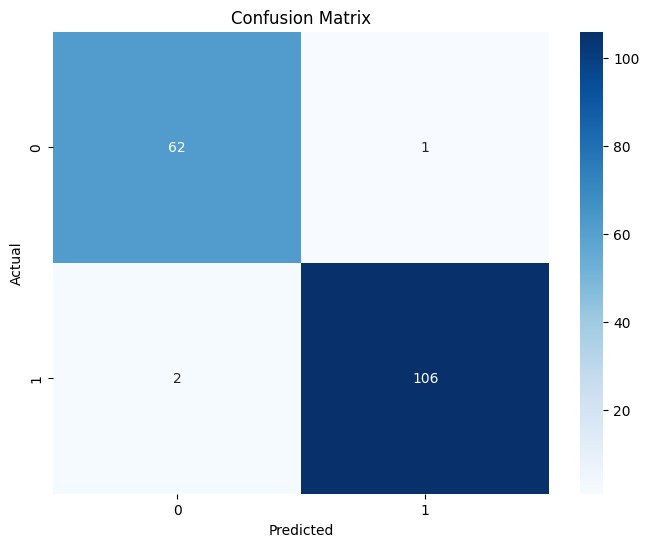

In [6]:
# Make predictions on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model's performance
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
# Save the best model and the preprocessing steps
dump(best_model, 'best_cancer_model_pipeline.joblib')

['best_cancer_model_pipeline.joblib']

In [11]:
import joblib
# Load the trained pipeline (including preprocessing, feature engineering, and the model)
inference_pipeline = joblib.load('best_cancer_model_pipeline.joblib')

# Define a function to make predictions
def predict(features):
    # Ensure the features are in the right shape (e.g., a 2D array)
    #features = np.array(features).reshape(1, -1)
    
    # Use the pipeline to make a prediction
    predictions = inference_pipeline.predict(features)
    
    return predictions

In [12]:
# Example feature set for a prediction (taken from the test set)
sample_features = X_test

# Make a prediction
prediction = predict(sample_features)

print(f"Predicted Class: {prediction}")

Predicted Class: [1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0
 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0
 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1]


In [27]:
import requests
import json

# Define the endpoint URL
url = 'http://localhost:5001/predict'

# Example feature set for a prediction
sample_data = {
    'features': [17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871,
                 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003,
                 0.006193, 25.38, 17.33, 184.6, 2019.0, 0.1622, 0.6656, 0.7119, 0.2654, 0.4601,
                 0.1189]
}
sample_data = X_test.iloc[0].to_json()
# Convert the data to JSON format
headers = {'Content-Type': 'application/json'}
data = json.dumps(sample_data)

# Send a POST request
response = requests.post(url, headers=headers, data=sample_data)



In [31]:
response.json()

{'prediction': 1}